## Config

In [1]:
import json
import pandas as pd
import numpy as np
import os

In [2]:
import spacy
nlp_spacy = spacy.load("en_core_web_sm")

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabrielvictorgomesferreira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielvictorgomesferreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
import gensim
from gensim.models.phrases import Phraser, Phrases

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
# Load the config file
with open('../config/config.json', 'r') as f:
    config = json.load(f)

file_path = config["data_loc"]

## Datasets

### Trait Phrases Dataset

In [7]:
# Read trait data
file_name = "Trait dictionary.txt"
final_path = os.path.join(file_path, file_name) 

# Read trait dictionary file
with open(final_path, "r", encoding="utf-8") as file:
    trait_phrases = set([phrase.lower().strip() for phrase in file if phrase.strip()])

print(f"Number of good phrases in the trait dictionary: {len(trait_phrases)}")
print(trait_phrases)

Number of good phrases in the trait dictionary: 22719
{'right kidney wet weight to body weight ratio', 'incisor', 'basal ganglion', 'percentage of study population displaying prostate tumorous lesions at a point in time', 'calculated pancreas insulin level', 'score for pda', 'plasma retinol', 'prostate mass', 'cd8-positive, alpha-beta cytotoxic t-cell morphology trait', 'heart muscle trabeculae morphology', 'large intestine length', 'serum anti-porcine type 2 collagen antibody titer', 'type 2 helper t cell', 'calculated plasma noradrenaline', 'channel response', 'spiral crest morphology', 'blood island morphology', 'lung wet weight as percentage of body weight', 'circulating il-18', 'sex gland secretion', 'longissimus thoracis weight', 'shank morphology trait', 'adipocyte absolute fatty acid secretion', 'calculated weight of islet beta cells in the head region of pancreas', 'calculated femoral neck cross-sectional area', 'plasma alcohol level', 'plasma progesterone', 'right ventricular

### Corpus Dataset

In [8]:
file_name = "QTL_text.json"
final_path = os.path.join(file_path, file_name) 

# Load json file
df = pd.read_json(final_path)
print(f"Shape of the original dataset: {df.shape}", "\n")

df.head()

Shape of the original dataset: (11278, 5) 



PMID                                            Journal  \
0  17179536                  J Anim Sci. 2007 Jan;85(1):22-30.   
1  17177700         J Anim Breed Genet. 2006 Dec;123(6):414-8.   
2  17129674  Vet Parasitol. 2007 Apr 10;145(1-2):2-10. Epub...   
3  17121599                 Anim Genet. 2006 Dec;37(6):543-53.   
4  17057239  Genetics. 2006 Dec;174(4):2119-27. Epub 2006 O...   

                                               Title  \
0  Variance component analysis of quantitative tr...   
1  Single nucleotide polymorphism identification,...   
2  Genetic resistance to Sarcocystis miescheriana...   
3  Results of a whole-genome quantitative trait l...   
4  Unexpected high polymorphism at the FABP4 gene...   

                                            Abstract  Category  
0  In a previous study, QTL for carcass compositi...         1  
1  Pituitary adenylate cyclase-activating polypep...         0  
2  Clinical and parasitological traits of Sarcocy...         0  
3  A whole-genome quantitative trait locus (QTL) ...         1  
4  Fatty acid bing protein 4 (FABP4) plays a key ...         0

## Pre-processing and other requirements

### Given Pre-Processing Requirements

In [9]:
# "In this project, you will need to use "Abstract" and "Category", and you can ignore the other fields."
df = df[['Abstract', 'Category']]
print(f"Shape before filtering: {df.shape}", "\n")

# "In this project, you need to ignore papers in Category ‘0’."
df = df[df['Category'] == 1].reset_index(drop=True)
print(f"Shape after filtering: {df.shape}", "\n")

df.head()

Shape before filtering: (11278, 2) 

Shape after filtering: (1007, 2) 



Abstract  Category
0  In a previous study, QTL for carcass compositi...         1
1  A whole-genome quantitative trait locus (QTL) ...         1
2  A partial genome scan using microsatellite mar...         1
3  BACKGROUND: The rate of pubertal development a...         1
4  Previously, quantitative trait loci (QTL) for ...         1

### NLP Pre-Processing

In [10]:
# Set stop words
stop_words = set(stopwords.words('english'))

# Set lemmatizer
lemmatizer = WordNetLemmatizer()

# Defining NLP Pre-Processing steps. These steps were the one that highlighted the most on my exploration phase
def nlp_preprocessing(abstract_tokenized):
    abstract_tokenized = abstract_tokenized.apply(lambda doc: doc.lower()) # Lowercasing txt
    abstract_tokenized = abstract_tokenized.apply(lambda doc: doc.translate(str.maketrans("", "", string.punctuation))) # Removing punctuations from the text
    # abstract_tokenized = abstract_tokenized.apply(lambda doc: re.sub(r"\d+", "", doc)) # Removing numbers from the text
    abstract_tokenized = abstract_tokenized.apply(lambda doc: [token for token in word_tokenize(doc) if token not in stop_words]) # Tokenizing and removing stop words from the text
    abstract_tokenized = abstract_tokenized.apply(lambda doc: [lemmatizer.lemmatize(token, pos=wordnet.NOUN) for token in doc]) # Convert words to their base
    abstract_tokenized = abstract_tokenized.apply(lambda doc: [token.strip() for token in doc if token.strip() and len(token)>1]) # Removing extra space
    return abstract_tokenized

# https://medium.com/@lingostat/tf-idf-for-text-preprocessing-in-machine-learning-a66b29774040

In [11]:
# Applying pre-defined pre-processing steps
df_processed = df.copy()
df_processed['abstract_nltk_token'] = nlp_preprocessing(df_processed['Abstract'])
df_processed['abstract_nltk_text'] = df_processed['abstract_nltk_token'].apply(lambda token: " ".join(token))
df_processed.head()

Abstract  Category  \
0  In a previous study, QTL for carcass compositi...         1   
1  A whole-genome quantitative trait locus (QTL) ...         1   
2  A partial genome scan using microsatellite mar...         1   
3  BACKGROUND: The rate of pubertal development a...         1   
4  Previously, quantitative trait loci (QTL) for ...         1   

                                 abstract_nltk_token  \
0  [previous, study, qtl, carcass, composition, m...   
1  [wholegenome, quantitative, trait, locus, qtl,...   
2  [partial, genome, scan, using, microsatellite,...   
3  [background, rate, pubertal, development, wean...   
4  [previously, quantitative, trait, locus, qtl, ...   

                                  abstract_nltk_text  
0  previous study qtl carcass composition meat qu...  
1  wholegenome quantitative trait locus qtl scan ...  
2  partial genome scan using microsatellite marke...  
3  background rate pubertal development weaning e...  
4  previously quantitative trait locus qtl tenthr...

## Analysis

### Analysis Without Key-Phrases

#### Task 1
Use wordcloud to visualize words in this corpus. The figure should be 800*800, with white background color. You will need to generate two word cloud images: 1) use word frequency, and 2) use tf-idf 
You may find the following libraries useful for this task: WordCloud


##### 1) Frequency Base

In [13]:
# Define input text
input_text = " ".join(df_processed['abstract_nltk_text'])
input_text

'previous study qtl carcass composition meat quality identified commercial finisher cross main objective current study confirm fine map qtl ssc4 ssc11 genotyping increased number individual marker analyze data using combined linkage linkage disequilibrium analysis method modified version method excludes linkage disequilibrium information analysis enabling comparison result based linkage information result based combined linkage linkage disequilibrium information nine additional paternal halfsib family genotyped 18 marker resulting total 1855 animal genotyped 15 13 marker ssc4 ssc11 respectively qtl affecting meat color ssc4 confirmed whereas qtl affecting lm weight could confirmed combined linkage linkage disequilibrium analysis resulted identification new significant effect 14 trait chromosome heritabilities qtl effect ranged 18 132 analysis contributed accurate positioning qtl characterized phenotypic effect however result showed even greater marker density required take full advanta

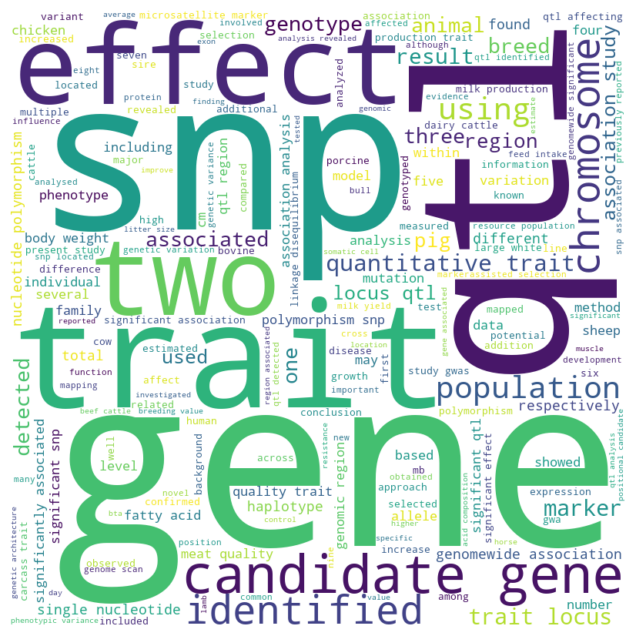

In [14]:
# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(input_text)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### 2) TD-IDF Base

In [15]:
# Define input token
input_string = df_processed['abstract_nltk_token'].apply(lambda token: " ".join(token))
input_string

0       previous study qtl carcass composition meat qu...
1       wholegenome quantitative trait locus qtl scan ...
2       partial genome scan using microsatellite marke...
3       background rate pubertal development weaning e...
4       previously quantitative trait locus qtl tenthr...
                              ...                        
1002    copy number variation cnvs major source struct...
1003    body size important indicator growth health sh...
1004    genomewide association study gwas performed id...
1005    gastrointestinal nematode gin infection negati...
1006    animal temperament defined consistent behavior...
Name: abstract_nltk_token, Length: 1007, dtype: object

In [64]:
# https://medium.com/@lingostat/tf-idf-for-text-preprocessing-in-machine-learning-a66b29774040

# Compute TF-IDF
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(input_string)
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
tfidf_word = dict(zip(tfidf_vec.get_feature_names_out(), tfidf_scores))
print(tfidf_word)

{'000': 0.00028834969972241806, '0000001': 0.00010948478316660998, '00000175': 0.00011511931023008306, '0000031': 0.00011511931023008306, '0000049': 0.00011929832619287433, '000005': 0.00010398093271461983, '00001': 0.0011361488013250738, '000010': 6.032645733710252e-05, '0000100040': 0.00010103440259484277, '0000100053': 0.00010734116608276182, '0000100125': 0.00010103440259484277, '0000100257': 8.423062966877086e-05, '00002': 0.00014034825325022796, '0000200013': 0.00010103440259484277, '00003': 0.00025820728710614397, '00005': 0.00017187502055708998, '00006': 0.00017211178347079244, '00007': 0.00019883547710636986, '00009': 7.52616142859341e-05, '0001': 0.0025041096131053313, '00011': 0.0001734491405453723, '00014': 9.148794690870885e-05, '00016': 9.397312207780705e-05, '00018': 0.00011500497430592832, '0002': 0.0007219464523365205, '00023': 7.52616142859341e-05, '0003': 0.0006592137104028231, '00032': 0.00010734116608276182, '00038': 8.776486314387148e-05, '0004': 0.000390022697809

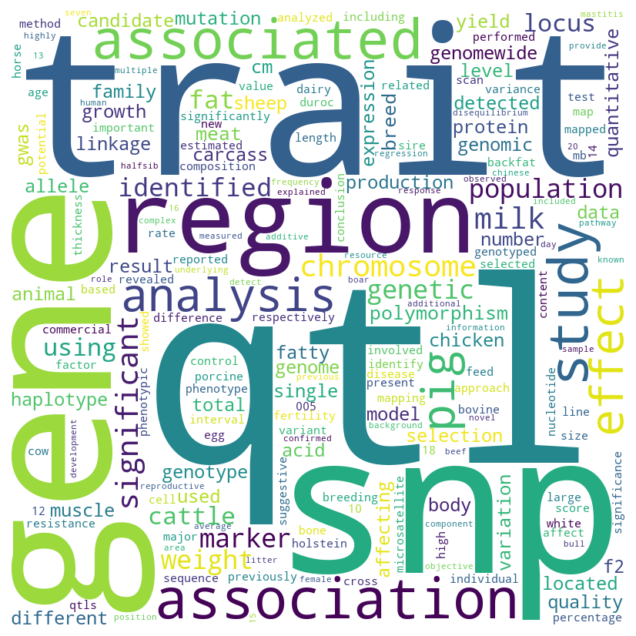

In [50]:
# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(tfidf_word)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### Top TF-IDF Score Words

In [51]:
# Sort and print highest ranked words
top_words = sorted(tfidf_word.items(), key=lambda x: x[1], reverse=True)[:10]
top_words_list, top_scores_list = zip(*top_words)
for word, score in top_words:
    print(f"{word}: {round(score, 4)}")

qtl: 0.0613
trait: 0.0461
snp: 0.0458
gene: 0.0397
region: 0.0283
association: 0.026
associated: 0.0254
study: 0.0253
analysis: 0.0251
pig: 0.0249


#### Task 2 

Train a Word2Vec model on this corpus, with the following parameters
vector_size=100, window=5, min_count=10
For each of the top 10 tf-idf words, print the 20 most similar words.

In [52]:
# Document body
abstract_nltk = df_processed['abstract_nltk_token']

# Define model Word2Vec model
word2vec_model = gensim.models.Word2Vec(
    vector_size=100,
    window=5,
    min_count=10)

# Build Vocabulary
word2vec_model.build_vocab(abstract_nltk)

# Train model
word2vec_model.train(abstract_nltk, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

## https://www.youtube.com/watch?v=Q2NtCcqmIww

(545670, 767850)

In [53]:
# Dictionary to save values
most_similar_dict = {}

# Print and collect vales
for word in top_words:
    similar_words = word2vec_model.wv.most_similar(word[0], topn=20)
    print(f"{word[0]} → {', '.join([w[0] for w in similar_words])}")

    most_similar_dict[word[0]] = [(str(w[0]) + ":" + str(round(w[1], 4))) for w in similar_words]

# Create data-frame
df_test = pd.DataFrame.from_dict(most_similar_dict, orient='index')
df_test.index = range(1, len(df_test) + 1)
df_test.columns = [f"Similar {i+1}" for i in range(df_test.shape[1])]
df_test.insert(0, "Top Word", top_words_list)
df_test.insert(1, "TF-IDF Score", [round(score, 4) for score in top_scores_list])

df_test

qtl → qtls, mapped, previously, detected, reported, locus, suggestive, chromosome, identified, chromosomal, several, region, putative, coincided, chromosomewide, harboring, mb, ssc, 22, pleiotropic
trait → affecting, quantitative, growth, locus, fatness, fertility, economically, meat, quality, underlying, beef, related, important, eggshell, carcass, complex, performance, affect, bone, influencing
snp → exon, five, singlenucleotide, single, intron, nucleotide, two, haplotype, three, polymorphism, revealed, within, showed, seven, flanking, six, four, bovine, one, located
gene → candidate, positional, mutation, functional, plausible, potential, causal, several, bovine, novel, region, variant, pathway, causative, involved, porcine, coding, reported, promising, harboring
region → identified, located, previously, mb, reported, novel, within, one, several, chromosome, detected, positional, mapped, centromeric, putative, chromosomal, candidate, mutation, close, found
association → genomewide, 

Top Word  TF-IDF Score          Similar 1              Similar 2  \
1           qtl        0.0613        qtls:0.9602          mapped:0.9387   
2         trait        0.0461   affecting:0.9235    quantitative:0.8778   
3           snp        0.0458        exon:0.9371             five:0.916   
4          gene        0.0397   candidate:0.9771      positional:0.9526   
5        region        0.0283  identified:0.9663         located:0.9483   
6   association        0.0260  genomewide:0.9478            gwas:0.9436   
7    associated        0.0254        found:0.882            also:0.8734   
8         study        0.0253    identify:0.9383       objective:0.9364   
9      analysis        0.0251  regression:0.9529  disequilibrium:0.9437   
10          pig        0.0249  commercial:0.9721           duroc:0.9695   

                  Similar 3          Similar 4           Similar 5  \
1         previously:0.9187    detected:0.9169     reported:0.9035   
2             growth:0.8692       locus:0.8602      fatness:0.8498   
3   singlenucleotide:0.9142      single:0.9107       intron:0.9102   
4           mutation:0.9034  functional:0.8796    plausible:0.8611   
5         previously:0.9334          mb:0.9228     reported:0.9102   
6           analysis:0.9286         gwa:0.8964     approach:0.8691   
7      significantly:0.8708     several:0.8452    plausible:0.8383   
8             detect:0.9208         aim:0.9202      present:0.9103   
9         genomewide:0.9427     linkage:0.9302  association:0.9286   
10          resource:0.9569       white:0.9483     erhualian:0.943   

            Similar 6            Similar 7          Similar 8  ...  \
1         locus:0.872    suggestive:0.8693  chromosome:0.8641  ...   
2    fertility:0.8366  economically:0.8207        meat:0.8186  ...   
3   nucleotide:0.9092           two:0.8979   haplotype:0.8969  ...   
4    potential:0.8557        causal:0.8504     several:0.8487  ...   
5        novel:0.9004         within:0.897          one:0.897  ...   
6    performed:0.8687      revealed:0.8594  regression:0.8591  ...   
7    promising:0.8281       receptor:0.825     located:0.8224  ...   
8         gwas:0.8989        genome:0.8969    conducted:0.889  ...   
9       mapping:0.925      approach:0.9239         gwa:0.9193  ...   
10   population:0.941         cross:0.9407       large:0.9378  ...   

           Similar 11             Similar 12        Similar 13  \
1      several:0.8538          region:0.8438   putative:0.8348   
2         beef:0.7962         related:0.7959  important:0.7951   
3     revealed:0.8816          within:0.8699      showed:0.868   
4       region:0.8297         variant:0.8287    pathway:0.8281   
5     detected:0.8886      positional:0.8829     mapped:0.8728   
6      imputed:0.8355         mapping:0.8355     method:0.8297   
7         near:0.8197      positional:0.8188     elovl6:0.8147   
8     approach:0.8744        previous:0.8727        gwa:0.8699   
9       marker:0.9097  microsatellite:0.9064      method:0.904   
10  intercross:0.9284         broiler:0.9275   pietrain:0.9274   

                 Similar 14             Similar 15          Similar 16  \
1          coincided:0.8343  chromosomewide:0.8311    harboring:0.8275   
2           eggshell:0.7933         carcass:0.7839      complex:0.7794   
3              seven:0.8666        flanking:0.8618          six:0.8463   
4          causative:0.8206        involved:0.8106      porcine:0.8031   
5        centromeric:0.8669        putative:0.8653  chromosomal:0.8605   
6   singlenucleotide:0.8293        previous:0.8282         test:0.8275   
7              fabp4:0.8124          bovine:0.8114         novel:0.811   
8                map:0.8681         perform:0.8471         fine:0.8364   
9           interval:0.9037            test:0.8985        mixed:0.8942   
10              rock:0.9271        landrace:0.9244       leghorn:0.924   

            Similar 17         Similar 18        Similar 19  \
1            mb:0.8247         ssc

### Analysis With Key-Phrases

### Task 3
Extract phrases and repeat task 1 and 2. You can be creative in phrase extraction. 


#### Gensim Bigram and Trigram

In [54]:
# https://tedboy.github.io/nlps/generated/generated/gensim.models.Phrases.html

# Document Body
abstract_tokenized = df_processed['abstract_nltk_token']

In [55]:
# Bigram and trigram
bigram = Phraser(Phrases(abstract_tokenized, min_count=2, threshold=15))
trigram = Phraser(Phrases(bigram[abstract_tokenized], min_count=2, threshold=15))
bigram_token = [bigram[doc] for doc in abstract_tokenized]
trigram_token = [trigram[bigram[doc]] for doc in abstract_tokenized]
bigram_text = " ".join([" ".join(token) for token in bigram_token])
trigram_text = [" ".join(token) for token in trigram_token]
print(bigram_token[0])
print(bigram_text)

['previous_study', 'qtl', 'carcass_composition', 'meat_quality', 'identified', 'commercial', 'finisher', 'cross', 'main_objective', 'current_study', 'confirm', 'fine_map', 'qtl', 'ssc4', 'ssc11', 'genotyping', 'increased', 'number', 'individual', 'marker', 'analyze_data', 'using', 'combined_linkage', 'linkage_disequilibrium', 'analysis', 'method', 'modified', 'version', 'method', 'excludes', 'linkage_disequilibrium', 'information', 'analysis', 'enabling', 'comparison', 'result', 'based', 'linkage', 'information', 'result', 'based', 'combined_linkage', 'linkage_disequilibrium', 'information', 'nine', 'additional', 'paternal_halfsib', 'family', 'genotyped', '18', 'marker', 'resulting', 'total', '1855', 'animal_genotyped', '15', '13', 'marker', 'ssc4', 'ssc11', 'respectively', 'qtl_affecting', 'meat_color', 'ssc4', 'confirmed', 'whereas', 'qtl_affecting', 'lm', 'weight', 'could_confirmed', 'combined_linkage', 'linkage_disequilibrium', 'analysis', 'resulted', 'identification', 'new', 'sign

##### Frequency Based

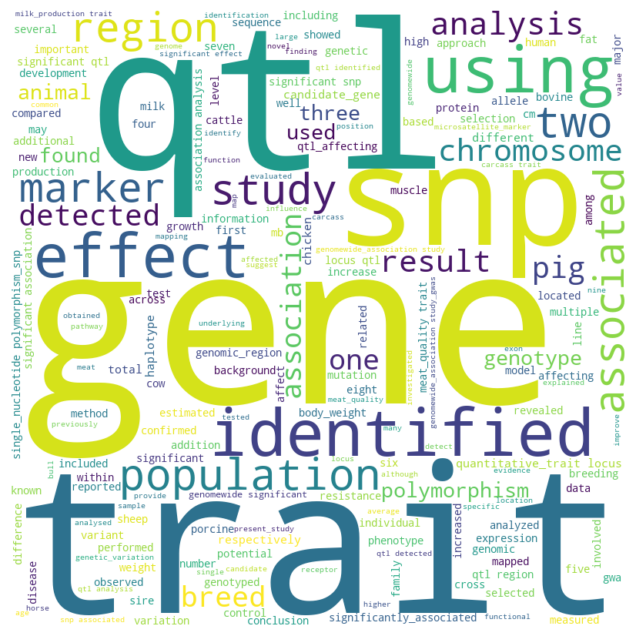

In [56]:
# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(bigram_text)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### TF-IDF Score Base

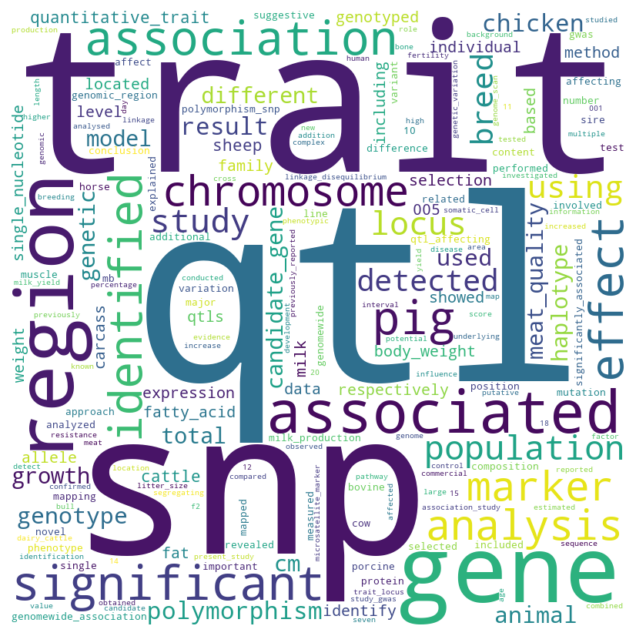

In [57]:
# Compute TF-IDF
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform([" ".join(token) for token in bigram_token])

tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
tfidf_word = dict(zip(tfidf_vec.get_feature_names_out(), tfidf_scores))

# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(tfidf_word)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
# Sort highest ranked words
top_words = sorted(tfidf_word.items(), key=lambda x: x[1], reverse=True)[:10]
top_words_list, top_scores_list = zip(*top_words)

for word, score in top_words:
    print(f"{word}: {round(score, 4)}")

qtl: 0.0597
trait: 0.0435
snp: 0.042
gene: 0.034
region: 0.0244
associated: 0.0232
significant: 0.023
association: 0.0225
pig: 0.0221
effect: 0.0221


##### Task 3 -> Task 2 

Train a Word2Vec model on this corpus, with the following parameters
vector_size=100, window=5, min_count=10
For each of the top 10 tf-idf words, print the 20 most similar words.

In [59]:
# Define model Word2Vec model
word2vec_model = gensim.models.Word2Vec(
    vector_size=100,
    window=5,
    min_count=10)

# Build Vocabulary
word2vec_model.build_vocab(bigram_token)

# Train model
word2vec_model.train(bigram_token, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)


(404539, 648925)

In [60]:
# Dictionary to save values
most_similar_dict = {}

# Print and collect vales
for word in top_words:
    similar_words = word2vec_model.wv.most_similar(word[0], topn=20)
    print(f"{word[0]} → {', '.join([w[0] for w in similar_words])}")

    most_similar_dict[word[0]] = [(str(w[0]) + ":" + str(round(w[1], 4))) for w in similar_words]

# Create data-frame
df_test = pd.DataFrame.from_dict(most_similar_dict, orient='index')
df_test.index = range(1, len(df_test) + 1)
df_test.columns = [f"Similar {i+1}" for i in range(df_test.shape[1])]
df_test.insert(0, "Top Word", top_words_list)
df_test.insert(1, "TF-IDF Score", [round(score, 4) for score in top_scores_list])

df_test

qtl → qtls, detected, suggestive, chromosome, region, mb, identified, located, genomewide, one, found, respectively, mapped, four, significant, ssc7, level, 12, sus_scrofa, explained
trait → growth, important, carcass, production, may, meat, meat_quality, affect, complex, background, related, fat, increase, improve, muscle, genetic_architecture, economically_important, would, meat_production, performance
snp → genomewide, found, respectively, three, five, two, four, suggestive, located, detected, significantly_associated, one, identified, 005, association, significant, mb, level, haplotype, 10
gene → candidate_gene, intron, positional_candidate, porcine, protein, novel, variant, exon, bovine, coding, receptor, promoter_region, utr, coding_region, investigate, associated, sequence, genomic_region, containing, potential
region → located, identified, mb, detected, one, chromosome, suggestive, found, genomewide, qtl, qtls, respectively, significant, four, 12, level, within, mapped, 10, two

Top Word  TF-IDF Score                  Similar 1          Similar 2  \
1           qtl        0.0597                qtls:0.9941    detected:0.9941   
2         trait        0.0435              growth:0.9986    important:0.998   
3           snp        0.0420          genomewide:0.9951       found:0.9939   
4          gene        0.0340      candidate_gene:0.9957       intron:0.995   
5        region        0.0244             located:0.9979  identified:0.9967   
6    associated        0.0232      located_within:0.9985       novel:0.9984   
7   significant        0.0230           chromosome:0.994   identified:0.994   
8   association        0.0225           haplotype:0.9956       three:0.9954   
9           pig        0.0221          commercial:0.9981      cattle:0.9979   
10       effect        0.0221  showed_significant:0.9983    observed:0.9982   

                      Similar 3          Similar 4  \
1             suggestive:0.9927  chromosome:0.9921   
2                carcass:0.9976  production:0.9976   
3           respectively:0.9929        three:0.992   
4   positional_candidate:0.9949     porcine:0.9941   
5                     mb:0.9967    detected:0.9957   
6    previously_reported:0.9984      several:0.998   
7             genomewide:0.9938     located:0.9933   
8                 showed:0.9953       seven:0.9951   
9             population:0.9978       sheep:0.9976   
10                  also:0.9981          rfi:0.998   

                          Similar 5             Similar 6  \
1                     region:0.9917             mb:0.9913   
2                        may:0.9975           meat:0.9974   
3                       five:0.9919            two:0.9918   
4                    protein:0.9936          novel:0.9935   
5                        one:0.9943     chromosome:0.9943   
6                      within:0.998  candidate_gene:0.998   
7                   detected:0.9927     suggestive:0.9905   
8   significantly_associated:0.9951           exon:0.9949   
9                      breed:0.9975             f2:0.9974   
10                  addition:0.9979           0001:0.9978   

              Similar 7                   Similar 8  ...  \
1     identified:0.9905              located:0.9901  ...   
2   meat_quality:0.9973               affect:0.9972  ...   
3           four:0.9915           suggestive:0.9914  ...   
4        variant:0.9934                 exon:0.9934  ...   
5     suggestive:0.9934                 found:0.993  ...   
6       revealed:0.9979                 ssc8:0.9979  ...   
7         region:0.9904                  snp:0.9902  ...   
8           five:0.9949               marker:0.9946  ...   
9       breeding:0.9973              chicken:0.9969  ...   
10           001:0.9976  allele_substitution:0.9976  ...   

                         Similar 11             Similar 12  \
1                       found:0.988    respectively:0.9871   
2                     related:0.997             fat:0.9969   
3   significantly_associated:0.9911              one:0.991   
4                    receptor:0.993  promoter_region:0.993   
5                       qtls:0.9917    respectively:0.9915   
6                  confirmed:0.9977            ssc1:0.9977   
7               respectively:0.9858             one:0.9851   
8                   revealed:0.9944             two:0.9944   
9                  phenotype:0.9967     large_white:0.9967   
10                  variance:0.9975            p005:0.9975   

            Similar 13            Similar 14              Similar 15  \
1        mapped:0.9868           four:0.9861      significant:0.9848   
2      increase:0.9968        improve:0.9968           muscle:0.9968   
3    identified:0.9909            005:0.9907      association:0.9902   
4           utr:0.9929  coding_region:0.9929      investigate:0.9925   
5   significant:0.9904           four:0.9896               12:0.9871   
6           six:0.9976          close:0.9976             ssc2:0.9975   
7           qtl:0.9848

#### Main result: 
- 3.	How many phrases you extracted can be found in the trait dictionary (by exact string matching)? 

In [63]:
print(f"Number of good phrases in the trait dictionary: {len(trait_phrases)}")
print(trait_phrases)

Number of good phrases in the trait dictionary: 22719
{'right kidney wet weight to body weight ratio', 'incisor', 'basal ganglion', 'percentage of study population displaying prostate tumorous lesions at a point in time', 'calculated pancreas insulin level', 'score for pda', 'plasma retinol', 'prostate mass', 'cd8-positive, alpha-beta cytotoxic t-cell morphology trait', 'heart muscle trabeculae morphology', 'large intestine length', 'serum anti-porcine type 2 collagen antibody titer', 'type 2 helper t cell', 'calculated plasma noradrenaline', 'channel response', 'spiral crest morphology', 'blood island morphology', 'lung wet weight as percentage of body weight', 'circulating il-18', 'sex gland secretion', 'longissimus thoracis weight', 'shank morphology trait', 'adipocyte absolute fatty acid secretion', 'calculated weight of islet beta cells in the head region of pancreas', 'calculated femoral neck cross-sectional area', 'plasma alcohol level', 'plasma progesterone', 'right ventricular

In [65]:
bi_unique = set()
bi_good_phrases = [[token for token in doc if "_" in token] for doc in bigram_token]
bi_good_phrases = [[token.replace("_", " ") for token in doc] for doc in bi_good_phrases]

for doc in bi_good_phrases:
    bi_unique.update(doc) 

print(f"Number of good phrases in the trait dictionary: {len(bi_unique)}")
print(bi_unique)

Number of good phrases in the trait dictionary: 2944
{'meat production', 'cooperative dairy', 'illumina bovine', 'danish jersey', 'gemma emmax', 'primer designed', 'imputed wholegenome', 'information content', 'genomewide rapid', 'generalized linear', 'beadchip illumina', 'polish large', 'spanish purebred', 'anal atresia', 'marking 005', 'repository population', 'illumina inc', 'permutation test', 'indicate possible', 'investigated whether', 'result supported', 'grammargc approach', 'bone density', 'produced mating', 'transcription factor', 'draft horse', 'might help', 'length tail', 'biological function', 'inverted teat', '139 f2', 'dna sequence', 'teat udder', 'mutation underlying', 'autosomal chromosome', 'average distance', 'regulator muscle', '190 day', 'brown swiss', 'dilution phenotype', 'mum 010', 'virus mdv', 'occurrence clinical', 'oc fetlock', 'r2 value', 'chromosome 10', 'igg2 response', 'developmental stage', 'aim study', 'intergenic region', 'growth hormone', 'heart weigh

In [73]:
# Calculate key phrase coverage
coverage_percentage = round(len(bi_unique) / len(trait_phrases) * 100, 2)
print(f"The key phrase extractor identified {coverage_percentage}% of the key phrases present in the trait file.")

The key phrase extractor identified 12.96% of the key phrases present in the trait file.


##### Analysis

In [77]:
# Compare gensim vs. trait phrases
matching_phrases = bi_unique & trait_phrases
match_count = len(matching_phrases)

# Calculate percentage representation
match_percentage = round((match_count / len(trait_phrases)) * 100, 2)

print(f"Total Exact Matches: {match_count}")
print(f"This represents {match_percentage}% of all phrases in the trait dictionary.")
print(f"Our extractor captured {coverage_percentage}% of all possible key phrases, but only {match_percentage}% were exact matches to known trait phrases.")
print("\nMatching Phrases:", list(matching_phrases))

Total Exact Matches: 115
This represents 0.51% of all phrases in the trait dictionary.
Our extractor captured 12.96% of all possible key phrases, but only 0.51% were exact matches to known trait phrases.

Matching Phrases: ['sperm motility', 'back fat', 'serum ige', 'body weight', 'nervous system', 'heart girth', 'connective tissue', 'bone density', 'chest girth', 'loin muscle', 'ovarian follicle', 'meat color', 'backfat thickness', 'milk yield', 'udder morphology', 'muscle fiber', 'carcass weight', 'pregnancy rate', 'adipose tissue', 'cortical bone', 'blood cell', 'uterine horn', 'eye muscle', 'thoracic vertebra', 'rib eye', 'wound healing', 'hemoglobin concentration', 'shank diameter', 'carcass length', 'skeletal muscle', 'chest width', 'intramuscular fat', 'feeding behavior', 'body conformation', 'heart weight', 'udder depth', 'chest depth', 'male fertility', 'female fertility', 'longissimus thoracis', 'tibia length', 'ovulation rate', 'leg muscle', 'nipple number', 'feather pecking